In [1]:
import pandas as pd
from torch.utils.data import Dataset
import torch
import os
import random
import numpy as np
from torch import nn
from typing import Dict, Optional, Tuple, List
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, random_split
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import precision_score, f1_score, recall_score, classification_report

In [2]:
SEED = 42

torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
!git clone https://github.com/uhh-lt/TextGraphs17-shared-task.git

Cloning into 'TextGraphs17-shared-task'...
remote: Enumerating objects: 490, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 490 (delta 4), reused 6 (delta 2), pack-reused 480
Receiving objects: 100% (490/490), 36.83 MiB | 11.25 MiB/s, done.
Resolving deltas: 100% (55/55), done.
Updating files: 100% (328/328), done.


In [6]:
!ls TextGraphs17-shared-task

baselines  data  evaluation  question_graph_examples  README.md  reformat_data	visualization


In [66]:
train_dev_path = "TextGraphs17-shared-task/data/tsv/train.tsv"
test_path = "TextGraphs17-shared-task/data/tsv/test.tsv"

train_dev_df = pd.read_csv(train_dev_path, sep='\t')
test_df = pd.read_csv(test_path, sep='\t')

In [67]:
train_dev_questions = list(train_dev_df["question"].unique())
test_questions = list(test_df["question"].unique())
num_train_dev_questions = len(train_dev_questions)
random.shuffle(train_dev_questions)

### Splitting train into train/dev

In [68]:
train_ratio = 0.9

num_train_questions = int(num_train_dev_questions * train_ratio)
train_questions = set(train_dev_questions[:num_train_questions])
dev_questions = set(train_dev_questions[num_train_questions:])

print(f"Questions: train - {len(train_questions)}, dev - {len(dev_questions)}, test - {len(test_questions)}")

Questions: train - 3181, dev - 354, test - 1000


In [69]:
train_df = train_dev_df[train_dev_df["question"].isin(train_questions)]
dev_df = train_dev_df[train_dev_df["question"].isin(dev_questions)]


print(f"Train: {train_df.shape}")
print(f"Dev: {dev_df.shape}")
print(f"Test: {test_df.shape}")

Train: (33900, 10)
Dev: (3772, 10)
Test: (10961, 7)


In [70]:
train_df.loc[0, "graph"]

'{\'nodes\': [{\'type\': \'QUESTIONS_ENTITY\', \'name_\': \'Q794\', \'id\': 0, \'label\': \'Iran\'}, {\'type\': \'INTERNAL\', \'name_\': \'Q207991\', \'id\': 1, \'label\': \'Pahlavi dynasty\'}, {\'type\': \'ANSWER_CANDIDATE_ENTITY\', \'name_\': \'Q7293530\', \'id\': 2, \'label\': "Ruhollah Khomeini\'s return to Iran"}], \'links\': [{\'name_\': \'P17\', \'source\': 0, \'target\': 0, \'label\': \'country\'}, {\'name_\': \'P1365\', \'source\': 0, \'target\': 1, \'label\': \'replaces\'}, {\'name_\': \'P1366\', \'source\': 1, \'target\': 0, \'label\': \'replaced by\'}, {\'name_\': \'P17\', \'source\': 2, \'target\': 1, \'label\': \'country\'}]}'

In [71]:
train_df.head()

,sample_id,question,questionEntity,answerEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,correct,graph
0,0,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,Q7293530,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
1,1,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini's letter to Mikhail Gorbachev,Office of the Supreme Leader of Iran,Q5952984,Q794,Q16045000,False,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q417..."
2,2,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini,Office of the Supreme Leader of Iran,Q38823,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
3,3,Whst is the name of the head of state and high...,Iran,Office of the Supreme Leader of Iran,Office of the Supreme Leader of Iran,Q16045000,Q794,Q16045000,True,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
4,4,Whst is the name of the head of state and high...,Iran,Mohammad Reza Pahlavi and Soraya,Office of the Supreme Leader of Iran,Q63195813,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."


In [72]:
train_df["label"] = train_df["correct"].astype(np.float32)
dev_df["label"] = dev_df["correct"].astype(np.float32)
test_df["label"] = np.zeros(shape=test_df.shape[0], dtype=np.float32)
train_df["label"].head(5)

<ipython-input-72-f47deaeca3f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["label"] = train_df["correct"].astype(np.float32)
<ipython-input-72-f47deaeca3f5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df["label"] = dev_df["correct"].astype(np.float32)


0    0.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: label, dtype: float32

In [73]:
train_df["graph"] = train_df["graph"].apply(eval)
dev_df["graph"] = dev_df["graph"].apply(eval)
test_df["graph"] = test_df["graph"].apply(eval)

<ipython-input-73-3a975c0f4542>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["graph"] = train_df["graph"].apply(eval)
<ipython-input-73-3a975c0f4542>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df["graph"] = dev_df["graph"].apply(eval)


In [74]:
train_df.loc[0, "graph"]

{'nodes': [{'type': 'QUESTIONS_ENTITY',
   'name_': 'Q794',
   'id': 0,
   'label': 'Iran'},
  {'type': 'INTERNAL',
   'name_': 'Q207991',
   'id': 1,
   'label': 'Pahlavi dynasty'},
  {'type': 'ANSWER_CANDIDATE_ENTITY',
   'name_': 'Q7293530',
   'id': 2,
   'label': "Ruhollah Khomeini's return to Iran"}],
 'links': [{'name_': 'P17', 'source': 0, 'target': 0, 'label': 'country'},
  {'name_': 'P1365', 'source': 0, 'target': 1, 'label': 'replaces'},
  {'name_': 'P1366', 'source': 1, 'target': 0, 'label': 'replaced by'},
  {'name_': 'P17', 'source': 2, 'target': 1, 'label': 'country'}]}

In [75]:
train_df[["question", "answerEntity", "groundTruthAnswerEntity", "label"]].head(10)

,question,answerEntity,groundTruthAnswerEntity,label
0,Whst is the name of the head of state and high...,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,0.0
1,Whst is the name of the head of state and high...,Ruhollah Khomeini's letter to Mikhail Gorbachev,Office of the Supreme Leader of Iran,0.0
2,Whst is the name of the head of state and high...,Ruhollah Khomeini,Office of the Supreme Leader of Iran,0.0
3,Whst is the name of the head of state and high...,Office of the Supreme Leader of Iran,Office of the Supreme Leader of Iran,1.0
4,Whst is the name of the head of state and high...,Mohammad Reza Pahlavi and Soraya,Office of the Supreme Leader of Iran,0.0
5,Whst is the name of the head of state and high...,Mahmoud Ahmadinejad,Office of the Supreme Leader of Iran,0.0
6,Whst is the name of the head of state and high...,Hassan Rouhani,Office of the Supreme Leader of Iran,0.0
7,Whst is the name of the head of state and high...,Ayatollah Khamenei's Foreign Policy Orientation,Office of the Supreme Leader of Iran,0.0
8,Whst is the name of the head of state and high...,Ayatollah Ali Khamenei speaks about Iranian pr...,Office of the Supreme Leader of Iran,0.0
9,Whst is the name of the head of state and high...,Ali Khamenei bibliography,Office of the Supreme Leader of Iran,0.0


In [76]:
test_df[["question", "answerEntity"]].head(10)

,question,answerEntity
0,"After publishing A Time to Kill, which book di...",A Clash of Kings
1,"After publishing A Time to Kill, which book di...",A Feast for Crows
2,"After publishing A Time to Kill, which book di...",Fear and Loathing in Las Vegas
3,"After publishing A Time to Kill, which book di...",In Cold Blood
4,"After publishing A Time to Kill, which book di...",Into the Woods
5,"After publishing A Time to Kill, which book di...",Kongenes kamp
6,"After publishing A Time to Kill, which book di...",No Country for Old Men
7,"After publishing A Time to Kill, which book di...",No Country for Old Men
8,"After publishing A Time to Kill, which book di...",Slaughterhouse-Five
9,"After publishing A Time to Kill, which book di...",The Firm


In [77]:
class QuestionAnswerDataset(Dataset):

    def __init__(self, df, tokenizer, max_length, context_key="answerEntity",
                 tokenizer_truncation="only_first", graph_only=False):
        super(QuestionAnswerDataset).__init__()

        self.questions = df.question.values
        self.contexts = df[context_key].values
        self.labels = torch.tensor(df.label.values, dtype=torch.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.graph_only = graph_only
        if graph_only:
            self.tokenized_input = [tokenizer.encode_plus(y,
                              max_length=self.max_length,
                              padding="max_length",
                              truncation=tokenizer_truncation,
                              return_tensors="pt") \
                              for y in self.contexts]
        else:
            self.tokenized_input = [tokenizer.encode_plus(x, y,
                              max_length=self.max_length,
                              padding="max_length",
                              truncation=tokenizer_truncation,
                              return_tensors="pt", ) \
                          for x, y in zip(self.questions,
                                          self.contexts)]
        assert len(self.questions) == len(self.contexts) == len(self.labels)

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        return {
                "input_ids": self.tokenized_input[idx]["input_ids"][0],
                "attention_mask" : self.tokenized_input[idx]["attention_mask"][0],
                "labels": self.labels[idx]}

In [78]:
# model_name="roberta-base"
model_name="sentence-transformers/all-mpnet-base-v2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

freeze_embeddings = True
if freeze_embeddings:
    for param in bert_model.embeddings.parameters():
        param.requires_grad = False

freeze_layer_count = 5
if freeze_layer_count > 0:
    for layer in bert_model.encoder.layer[:freeze_layer_count]:
        for param in layer.parameters():
            param.requires_grad = False

print("# Trainable params: ", sum(p.numel() for p in bert_model.parameters() if p.requires_grad))

# Trainable params:  50206080


In [79]:
train_df_filtered = train_df.copy()
train_df_filtered.sort_values(by=["label", ], ascending=False, inplace=True)
train_df_filtered["label"].head()

34333    1.0
3845     1.0
22662    1.0
30080    1.0
8525     1.0
Name: label, dtype: float32

In [80]:
print(train_df_filtered.shape)
train_df_filtered.drop_duplicates(subset=["question", "answerEntity"], keep="first", inplace=True)
print(train_df_filtered.shape)

(33900, 11)
(31778, 11)


In [81]:
max_length = 128
train_dataset = QuestionAnswerDataset(train_df_filtered, tokenizer=tokenizer, max_length=max_length)
dev_dataset = QuestionAnswerDataset(dev_df, tokenizer=tokenizer, max_length=max_length)
test_dataset = QuestionAnswerDataset(test_df, tokenizer=tokenizer, max_length=max_length)

In [82]:
idx_bound = 2
for i in range(idx_bound):
    d = train_dataset[i]
    inp_ids = d["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(inp_ids)
    s = "".join((x.strip("#") if x.startswith("#") else f" {x}" for x in tokens))
    print(s)
    d = dev_dataset[i]
    inp_ids = d["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(inp_ids)
    s = "".join((x.strip("#") if x.startswith("#") else f" {x}" for x in tokens))
    print(s)
    d = test_dataset[i]
    inp_ids = d["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(inp_ids)
    s = "".join((x.strip("#") if x.startswith("#") else f" {x}" for x in tokens))
    print(s)
    print('---')

 <s> what is the first movie that starred the entire cast of characters iron man , captain american , thor , hulk and black widow ? </s> </s> the avengers </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
 <s> who wrote the britney spears song womanizer ? </s> </s> tom kelly </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p

In [83]:
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)

In [84]:
def train(model, iterator, optimizer, criterion, device,
          train_history=None, valid_history=None,):
    model.train()

    epoch_loss = 0
    history = []
    for i, batch in enumerate(tqdm(iterator)):

        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        output = model(inputs=input_ids, attention_mask=attention_mask,).squeeze(1)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())

    return epoch_loss / (i + 1)

def evaluate(model, iterator, criterion, device):
    model.eval()

    epoch_loss = 0

    true_labels = []
    pred_labels = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"]

            true_labels.extend(labels.cpu().numpy())
            labels = labels.to(device)


            output = model(inputs=input_ids, attention_mask=attention_mask,).squeeze(1)
            pred_probas = output.cpu().numpy()
            batch_pred_labels = (pred_probas >= 0.5) * 1

            loss = criterion(output, labels)

            pred_labels.extend(batch_pred_labels)
            epoch_loss += loss.item()

    valid_f1_score = f1_score(true_labels, pred_labels)
    return epoch_loss / (i + 1), valid_f1_score

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [85]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [86]:
def train_evaluate(bert_classifier, train_loader, dev_loader, optimizer, criterion, n_epochs,  checkpoint_fname, device):
    train_history = []
    valid_history = []
    valid_history_f1 = []

    best_valid_loss = float('inf')
    best_f1_score = 0.0

    for epoch in range(n_epochs):

        start_time = time.time()

        train_loss = train(bert_classifier, train_loader, optimizer, criterion, device, train_history, valid_history, )
        valid_loss, valid_f1_score = evaluate(bert_classifier, dev_loader, criterion, device)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        valid_history_f1.append(valid_f1_score)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

        clear_output(True)
        ax[0].plot(valid_history_f1, label='Val f1-score')
        ax[0].set_xlabel('Epoch')
        ax[0].set_title('Val f1-score')

        ax[1].plot(train_history, label='general train history')
        ax[1].set_xlabel('Epoch')
        ax[1].plot(valid_history, label='general valid history')

        plt.legend()
        plt.show()

        if valid_f1_score > best_f1_score:
            best_f1_score = valid_f1_score
            torch.save(bert_classifier.state_dict(), f'best-val-{checkpoint_fname}.pt')

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1: {valid_f1_score:.3f}')

In [87]:
def predict(model, data_loader, device):
    true_labels = []
    pred_labels = []

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            batch_true_labels = batch["labels"].cpu().numpy()


            pred_probas = model(inputs=input_ids, attention_mask=attention_mask,).squeeze(1)
            pred_probas = pred_probas.cpu().numpy()

            batch_pred_labels = (pred_probas >= 0.5) * 1

            pred_labels.extend(batch_pred_labels)
            true_labels.extend(batch_true_labels)
    return true_labels, pred_labels

In [88]:
class BertSimpleClassifier(nn.Module):
    def __init__(self, bert_text_encoder, dropout=0.1):
        super().__init__()

        self.bert_text_encoder = bert_text_encoder
        self.dropout = nn.Dropout(p=dropout)
        bert_hidden_dim = bert_text_encoder.config.hidden_size

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(bert_hidden_dim, bert_hidden_dim),
            nn.Dropout(p=dropout),
            nn.ReLU(),
            nn.Linear(bert_hidden_dim, 1),
        )


    def forward(self, inputs, attention_mask,):
        last_hidden_states = self.bert_text_encoder(inputs, attention_mask=attention_mask,
                                                    return_dict=True)['last_hidden_state']
        text_cls_embeddings = torch.stack([elem[0, :] for elem in last_hidden_states])
        proba = self.classifier(text_cls_embeddings)
        return proba

In [89]:
N_EPOCHS = 5
DROPOUT = 0.2

In [90]:
bert_simple_clf = BertSimpleClassifier(bert_model, dropout=DROPOUT).to(device)
optimizer = optim.Adam(bert_simple_clf.parameters(), lr=3e-5)
criterion = nn.BCEWithLogitsLoss().to(device)

In [91]:
class_counts = train_df["label"].value_counts()
pos_weight = class_counts[0] / class_counts[1]

pos_weight = torch.FloatTensor([pos_weight, ]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)

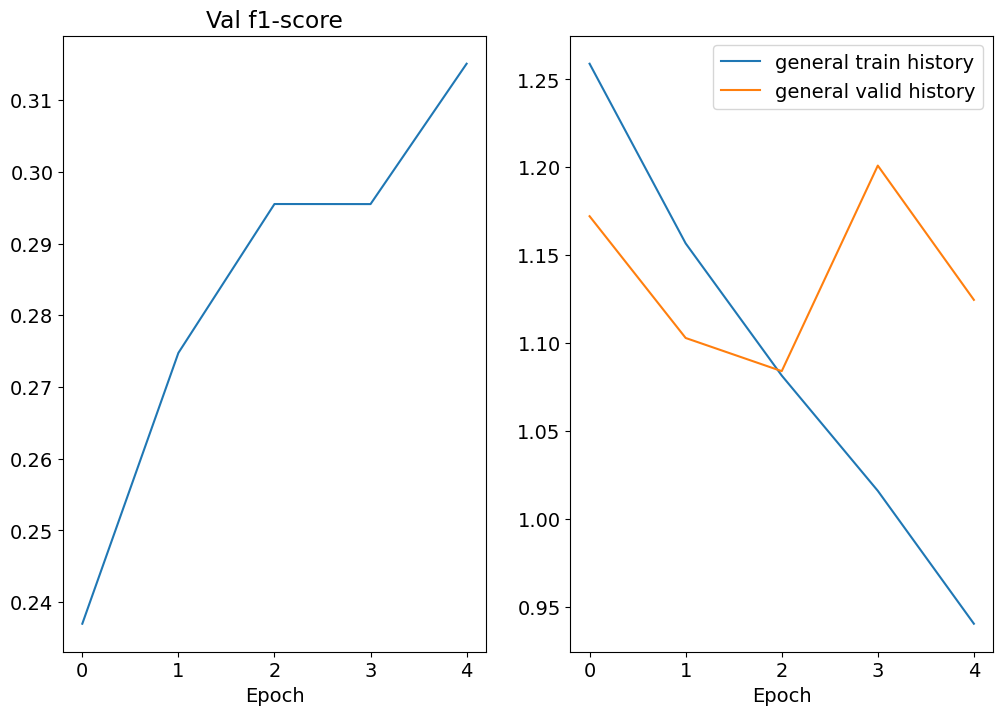

Epoch: 05 | Time: 9m 29s
	Train Loss: 0.940
	 Val. Loss: 1.125 |  Val. F1: 0.315


In [92]:
train_evaluate(bert_simple_clf, train_loader, dev_loader, optimizer,
               criterion, N_EPOCHS, "text_only_baseline", device)

In [93]:
bert_simple_clf.load_state_dict(torch.load('best-val-text_only_baseline.pt'))

<All keys matched successfully>

### Evaluation on dev set

In [94]:
true_labels, pred_labels = predict(bert_simple_clf, dev_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.21535393818544366,0.5869565217391305,0.3150984682713348


### Prediction on test set

In [95]:
true_labels, pred_labels = predict(bert_simple_clf, test_loader, device)
# print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

In [96]:
test_df["true_y"] = true_labels
test_df["prediction"] = pred_labels

In [97]:
test_pred_path = "test_pred_mpnet_nograph_baseline.tsv"
# test_df.to_csv(test_pred_path, sep='\t', index=False)
test_df[["sample_id", "prediction"]].to_csv(test_pred_path, sep='\t', index=False)

## Linearized graph baseline

In [ ]:
SEP_TOKEN = tokenizer.sep_token

In [ ]:
# Example:
# {'directed': True, 'multigraph': False, 'graph': {},
# 'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_': 'Q49', 'id': 0, 'label': 'North America'},
# {'type': 'ANSWER_CANDIDATE_ENTITY', 'name_': 'Q194057', 'id': 1, 'label': 'Mount Rainier'}],
# 'links': [{'name_': 'P30', 'source': 1, 'target': 0, 'label': 'continent'}]}
def linearize_graph(graph_dict):
    nodes = sorted((node_dict for node_dict in graph_dict["nodes"]), key=lambda d:d["id"])
    for n_id, node_dict in enumerate(nodes):
        assert n_id == node_dict["id"]
    src_node_id2links = {}
    for link_dict in graph_dict["links"]:
        link_src =  link_dict["source"]
        if src_node_id2links.get(link_src) is None:
            src_node_id2links[link_src] = []
        src_node_id2links[link_src].append(link_dict)
    graph_s = ""

    for n_id, node_dict in enumerate(nodes):
        links = src_node_id2links.get(n_id, list())
        start_label = node_dict["label"]
        if node_dict["type"] == "ANSWER_CANDIDATE_ENTITY":
            start_label = f"{SEP_TOKEN} {start_label} {SEP_TOKEN}"
        for link_dict in links:
            target_label = nodes[link_dict["target"]]["label"]
            if nodes[link_dict["target"]]["type"] == "ANSWER_CANDIDATE_ENTITY":
                target_label = f"{SEP_TOKEN} {target_label} {SEP_TOKEN}"
            link_s = f" {start_label}, {link_dict['label']}, {target_label} "
            graph_s += link_s

    return graph_s

In [ ]:
train_df["linearized_graph"] = train_df["graph"].apply(linearize_graph)
dev_df["linearized_graph"] = dev_df["graph"].apply(linearize_graph)
test_df["linearized_graph"] = test_df["graph"].apply(linearize_graph)

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
train_df["linearized_graph"].head()

In [ ]:
dev_df["linearized_graph"].head()

In [ ]:
test_df["linearized_graph"].head()

In [ ]:
# model_name="roberta-base"
model_name="sentence-transformers/all-mpnet-base-v2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

freeze_embeddings = True
if freeze_embeddings:
    for param in bert_model.embeddings.parameters():
        param.requires_grad = False

freeze_layer_count = 5
if freeze_layer_count > 0:
    for layer in bert_model.encoder.layer[:freeze_layer_count]:
        for param in layer.parameters():
            param.requires_grad = False

print("# Trainable params: ", sum(p.numel() for p in bert_model.parameters() if p.requires_grad))

In [ ]:
max_length = 128
train_dataset = QuestionAnswerDataset(train_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                      tokenizer_truncation="only_second")
dev_dataset = QuestionAnswerDataset(dev_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                    tokenizer_truncation="only_second")
test_dataset = QuestionAnswerDataset(test_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
                                     tokenizer_truncation="only_second")

In [ ]:
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)

In [ ]:
N_EPOCHS = 5
DROPOUT = 0.2

In [ ]:
bert_linearized_graph_clf = BertSimpleClassifier(bert_model, dropout=DROPOUT).to(device)
optimizer = optim.Adam(bert_linearized_graph_clf.parameters(), lr=3e-5)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
train_evaluate(bert_linearized_graph_clf, train_loader, dev_loader, optimizer,
               criterion, N_EPOCHS, "bert_linearized_graph_clf", device)

In [ ]:
bert_linearized_graph_clf.load_state_dict(torch.load('best-val-bert_linearized_graph_clf.pt'))

### Evaluation on dev set

In [ ]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, dev_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

### Prediction on test set

In [ ]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, test_loader, device)
# print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

In [ ]:
assert len(true_labels) == len(pred_labels)

In [ ]:
test_df["true_y"] = true_labels
test_df["prediction"] = pred_labels


In [ ]:
test_df.head()

In [ ]:
test_df[["question", "answerEntity", "groundTruthAnswerEntity", "true_y", "prediction", "label"]].head(50)

In [ ]:
test_pred_path = "test_pred_linearized_graph_baseline.tsv"
test_df[["sample_id", "prediction"]].to_csv(test_pred_path, sep='\t', index=False)

## Linearized graph only

In [ ]:
max_length = 128
train_dataset = QuestionAnswerDataset(train_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph", graph_only=True)
dev_dataset = QuestionAnswerDataset(dev_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph", graph_only=True)
test_dataset = QuestionAnswerDataset(test_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph", graph_only=True)

In [ ]:
idx_bound = 5
for i in range(idx_bound):
    d = train_dataset[i]
    inp_ids = d["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(inp_ids)
    s = "".join((x.strip("#") if x.startswith("#") else f" {x}" for x in tokens))
    print(s)


In [ ]:
batch_size = 64
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)

In [ ]:
N_EPOCHS = 5
DROPOUT = 0.2

In [ ]:
bert_linearized_graph_clf = BertSimpleClassifier(bert_model, dropout=DROPOUT).to(device)
optimizer = optim.Adam(bert_linearized_graph_clf.parameters(), lr=3e-5)
criterion = nn.BCEWithLogitsLoss()

In [ ]:
train_evaluate(bert_linearized_graph_clf, train_loader, dev_loader, optimizer,
               criterion, N_EPOCHS, "bert_linearized_graph_only_clf", device)

In [ ]:

bert_linearized_graph_clf.load_state_dict(torch.load('best-val-bert_linearized_graph_only_clf.pt'))

### Evaluation on dev set

In [ ]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, dev_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

### Prediction on test set

In [ ]:
true_labels, pred_labels = predict(bert_linearized_graph_clf, test_loader, device)
# print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

In [ ]:
assert len(true_labels) == len(pred_labels)

In [ ]:
test_df["true_y"] = true_labels
test_df["prediction"] = pred_labels


In [ ]:
test_df.head()

In [ ]:
test_df[["question", "answerEntity", "groundTruthAnswerEntity", "true_y", "prediction", "label"]].head(50)

In [ ]:
test_pred_path = "/content/drive/MyDrive/kgqa_workshop/final_test/test_pred_linearized_graph_only_baseline.tsv"
test_df[["sample_id", "prediction"]].to_csv(test_pred_path, sep='\t', index=False)

In [ ]:
test_pred_path = "test_pred_linearized_graph_only_baseline.tsv"
test_df[["sample_id", "prediction"]].to_csv(test_pred_path, sep='\t', index=False)